# 

___

In [1]:
import os

def windowsOrMacDirectories():
    """ Sets base directories for win or mac

       
    """
    if os.environ['COMPUTERNAME'] == 'SHEALMACLEARN':
        DropboxDirect = os.path.join("D:\Dropbox")
#     elif sys.platform.startswith('linux') or sys.platform.startswith('cygwin'):
#         # this excludes your current terminal "/dev/tty"
    elif sys.platform.startswith('darwin'):
        DropboxDirect = os.path.join("/Users/cswitzer/Dropbox")
    else:
        raise EnvironmentError('Unknown computer platform')
    
    baseDir = os.getcwd()
    dataDir = os.path.join(DropboxDirect, 'SonicationBehavior', 'SonBehData')
    figDir = os.path.join(DropboxDirect, 'SonicationBehavior', 'SonBehFigs')
    return baseDir, dataDir, figDir


baseDir, dataDir, figDir = windowsOrMacDirectories()
print(dataDir)

D:\Dropbox\SonicationBehavior\SonBehData


In [2]:
import pandas as pd

def readMyFile(filename):
    
    '''Read in csv 10x faster than pandas'''
    
    tmpdta = []
 
    with open(filename, newline="\n") as csvDataFile:
        csvReader = csv.reader(csvDataFile, delimiter=' ', quoting=csv.QUOTE_NONNUMERIC)
        for row in csvReader:
            tmpdta.append(row)
 
    return(pd.DataFrame(np.transpose(tmpdta)))

In [3]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import os
import csv
import time
from scipy import signal
import itertools as it

In [4]:
# read in dataset that was pre-classified
buzzClassDataDir = os.path.join("D:\Dropbox\SonicationBehavior\SonBehData\BuzzPartClassification")
buzzClass = pd.read_csv(os.path.join(buzzClassDataDir, 'BuzzClassifications.csv'))
print(buzzClass.shape)
buzzClass.head()

(200, 7)


,fileName,noise1,noise2,wing1,wing2,buzz1,buzz2
0,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,0,0,0,20000
1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,10000,20000,0,10000
2,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,0,0,0,20000
3,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,3000,10000,12500,20000
4,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...,0,0,0,0,0,20000


In [5]:
# read in all data into a single dataframe
bigList = []
freqSpec = []
for ii in range(buzzClass.shape[0]):
    tmp = readMyFile(buzzClass.fileName[ii])
    
    # pad with 0's
    tmp = readMyFile(buzzClass.fileName[ii])
    pad = np.arange(tmp.iloc[-1,0],tmp.iloc[-1,0]+ 0.02 - np.mean(np.diff(tmp.iloc[:,0])),  np.mean(np.diff(tmp.iloc[:,0])))
    zx = np.repeat(0, len(pad))
    pdff = pd.DataFrame( data = {"0":pad, "1":zx} )
    pdff.columns = tmp.columns

    tmp = pd.concat([tmp, pdff]).reset_index(drop = True)
    
    # calculate rolling variance
    tmp["varia"] = pd.Series((tmp.iloc[:,1] - np.mean(tmp.iloc[:,1]))).rolling(int(2000), center = True, min_periods = 1).var().tolist()
    
    # calculate frequency spectrum
    f, t, Sxx = signal.spectrogram(tmp.iloc[:,1], 200000, noverlap = 900, nperseg = 1000)
    Sxx = Sxx[0:50, :]
    #scale
    Sxx = Sxx - np.min(Sxx)
    Sxx = Sxx / np.max(Sxx)
    
    
    
    freqSpec.append(pd.DataFrame(np.transpose(Sxx)))
    
    # add classes to data
    tmp["buzz"] = 0
    tmp.loc[buzzClass.buzz1[ii]:buzzClass.buzz2[ii], "buzz"] = 1
    if(np.mod(ii, 10)) == 0:
        print(ii)
    
    tmp["filename"] = buzzClass.fileName[ii]
    bigList.append(tmp)

0
10
20
30
40
50
60
70
80
90
100
110
120
130
140
150
160
170
180
190


In [6]:
df = pd.concat(bigList)
df.reset_index(drop = True, inplace = True)

In [7]:
df.head()

,0,1,varia,buzz,filename
0,0.000000,0.001246,0.002879,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...
1,0.000005,0.001571,0.002876,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...
2,0.000010,-0.001999,0.002873,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...
3,0.000015,0.002544,0.002871,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...
4,0.000020,0.004167,0.002869,1,D:\Dropbox\SonicationBehavior\SonBehData\Sonic...


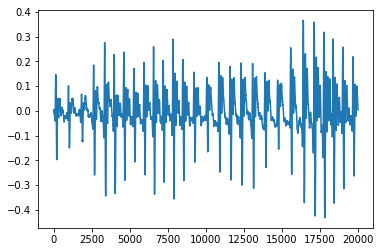

In [8]:
plt.plot(df.iloc[0:20000, 1])

In [9]:
df.shape

(4799800, 5)

In [10]:
from sklearn.preprocessing import MinMaxScaler

mm = MinMaxScaler((0,1))
mm.fit(df.iloc[:, 1].values.reshape(-1, 1))
df["scaledBuzz"] = mm.transform(df.iloc[:, 1].values.reshape(-1, 1))


subSamp = np.arange(0, 20000, step = 50)# np.arange(0, df.shape[0], step = 5)
plt.figure(figsize=(20,5))
plt.plot(np.array(df.index[subSamp]), np.array(df.iloc[subSamp,5]))
#plt.scatter(df.index[subSamp], df.iloc[subSamp,2]*10, s = 0.5, c = df.iloc[subSamp,3])
plt.show()
df.shape

In [12]:
# downsample dataset
print(df.shape)
subSamp = np.arange(0, df.shape[0], step = 10)# np.arange(0, df.shape[0], step = 5)
df = df.iloc[subSamp, :]
print(df.shape)

(4799800, 6)
(479980, 6)


In [13]:
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

C:\Users\calli\Anaconda3\envs\deeplearning\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [14]:
seq = df.loc[:,"scaledBuzz"]

# timesteps = np.linspace(0, 2, num = 2000000)
# freq = ((np.sin(timesteps*timesteps/2*10*2*np.pi) + 1)**3 > 4 ) + 0.3
# seq = np.sin((freq*100 * timesteps) * 2 * np.pi)
# plt.plot(timesteps, seq)
# plt.plot(timesteps, freq + 1)

from scipy import signal

f, t, Sxx = signal.spectrogram(np.array(seq), 200000, noverlap = 4000, nperseg = 5000)
Sxx = Sxx[0:10]
f = f[0:10]
plt.pcolormesh(t, f, Sxx)
plt.ylim(0,500)
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.show()

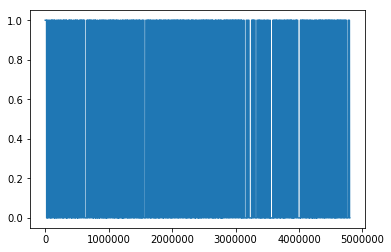

In [16]:
# buzzes = freq > 1.0
buzzes = df.buzz
plt.plot(buzzes[0:1000000])

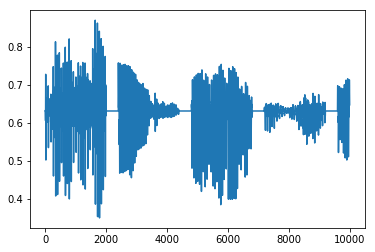

In [17]:
# scale dataset
from sklearn.preprocessing import MinMaxScaler
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(np.array(seq).reshape(-1,1))
plt.plot(dataset[0:10000])

In [18]:
# refref: look back should include Y, too...

In [44]:
# create dataset

# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

look_back = 500

trainX, trainY = create_dataset(dataset[0:int(dataset.shape[0]*0.75)], look_back)
testX, testY = create_dataset(dataset[(int(dataset.shape[0]*0.75)+1):], look_back)

print(trainY.shape)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))



(359484,)


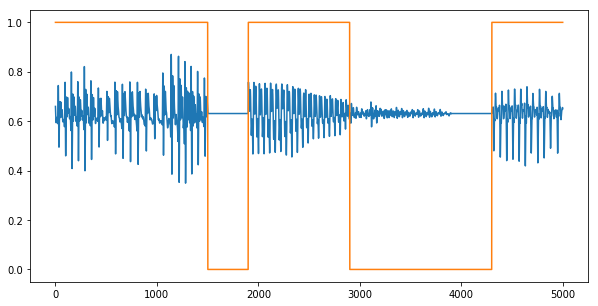

In [45]:
trainX.shape
plt.figure(figsize=[10,5])
plt.plot(trainX[0:5000, 0, -1])

trainY= np.array(buzzes[look_back:(trainX.shape[0]+look_back)])
plt.plot(trainY[0:5000])

# refref: alignment might be off

In [46]:
np.array(testY)

array([0.630776  , 0.63550413, 0.63829803, ..., 0.63102526, 0.63102526,
       0.63102526])

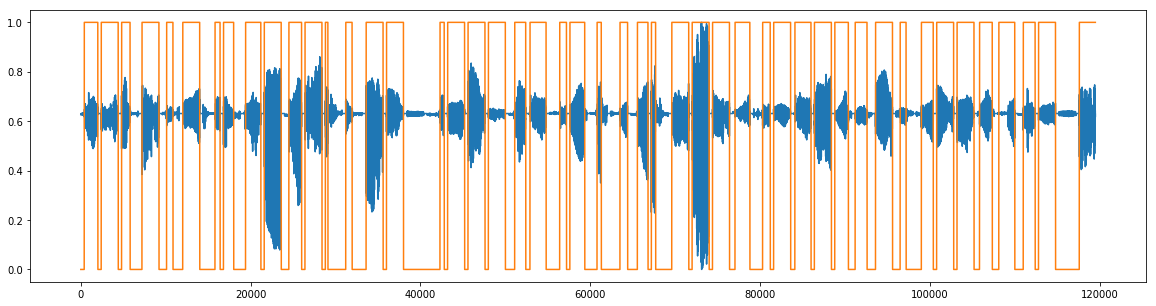

In [47]:
testY=np.array(buzzes[(trainX.shape[0]+look_back):(trainX.shape[0] + look_back + testY.shape[0])])
plt.figure(figsize=[20,5])
plt.plot(testX[0:500000,0,0])
plt.plot(testY[0:500000])

In [48]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.layers import Embedding
from keras.layers import LSTM
from keras.layers import CuDNNLSTM
from keras.layers import TimeDistributed
from keras.callbacks import EarlyStopping
from keras.callbacks import ReduceLROnPlateau
from keras.layers import Bidirectional

In [49]:
earlystop = EarlyStopping(monitor='loss', patience=300, verbose=1, mode='auto', min_delta = 0.0001)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.001)

In [ ]:
# refref: add bidirectionality
# create and fit the LSTM network
model = Sequential()
model.add(CuDNNLSTM(512, return_sequences = True, input_shape=(1, look_back)))
model.add((CuDNNLSTM(512, return_sequences = False)))
# refref add more layers, and increase lookback
#model.add(Dense(4, input_shape=(1, trainX.shape[2] )))
model.add((Dense(1, activation = "sigmoid")))
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [24]:
# save model
from keras.models import load_model

#model.save('C:\\Users\\calli\\Desktop\\my_model_2.h5')  # creates a HDF5 file 'my_model.h5'


# returns a compiled model
# identical to the previous one
model = load_model('C:\\Users\\calli\\Desktop\\my_model_2.h5')

In [ ]:
hitory = model.fit(trainX, trainY, validation_split = 0.1, epochs=200, batch_size=15000, verbose=1, callbacks = [earlystop, reduce_lr])

In [50]:
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 1, 512)            2076672   
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 512)               2101248   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 4,178,433
Trainable params: 4,178,433
Non-trainable params: 0
_________________________________________________________________
None


In [51]:
# more train
earlystop = EarlyStopping(monitor='loss', patience=100, verbose=1, mode='auto', min_delta = 0.0001)

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.0001)

hitory = model.fit(trainX, trainY, validation_split = 0.1, epochs=1000, batch_size=15000, verbose=1, callbacks = [earlystop, reduce_lr])

Train on 323535 samples, validate on 35949 samples
Epoch 1/1000
323535/323535 [==============================] - 2s 7us/step - loss: 0.2617 - acc: 0.8955 - val_loss: 0.3038 - val_acc: 0.8821
Epoch 2/1000
323535/323535 [==============================] - 2s 7us/step - loss: 0.2616 - acc: 0.8953 - val_loss: 0.3140 - val_acc: 0.8799
Epoch 3/1000
323535/323535 [==============================] - 2s 7us/step - loss: 0.2617 - acc: 0.8956 - val_loss: 0.3076 - val_acc: 0.8814
Epoch 4/1000
323535/323535 [==============================] - 2s 7us/step - loss: 0.2617 - acc: 0.8957 - val_loss: 0.3005 - val_acc: 0.8843
Epoch 5/1000
323535/323535 [==============================] - 2s 7us/step - loss: 0.2617 - acc: 0.8956 - val_loss: 0.3019 - val_acc: 0.8828
Epoch 6/1000
323535/323535 [==============================] - 2s 7us/step - loss: 0.2618 - acc: 0.8954 - val_loss: 0.3040 - val_acc: 0.8833
Epoch 7/1000
323535/323535 [==============================] - 2s 7us/step - loss: 0.2620 - acc: 0.8954 - val_

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


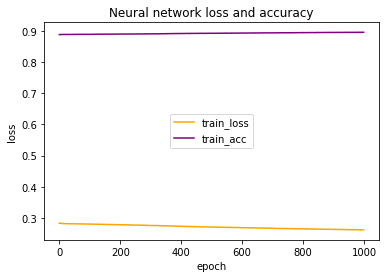

In [30]:
print(hitory.history.keys())


plt.plot(hitory.history['loss'], c = "orange")
plt.title('Neural network loss and accuracy')
plt.ylabel('loss')

plt.xlabel('epoch')




plt.plot(hitory.history['acc'], c = "purple")
plt.legend(['train_loss', 'train_acc'], loc='center')


plt.show()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc', 'lr'])


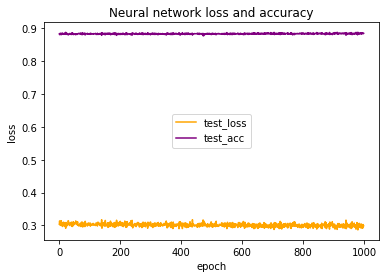

In [52]:
print(hitory.history.keys())


plt.plot(hitory.history['val_loss'], c = "orange")
plt.title('Neural network loss and accuracy')
plt.ylabel('loss')

plt.xlabel('epoch')




plt.plot(hitory.history['val_acc'], c = "purple")
plt.legend(['test_loss', 'test_acc'], loc='center')


plt.show()

In [ ]:
os.getcwd()

In [53]:
# save model
from keras.models import load_model

#model.save('C:\\Users\\calli\\Desktop\\my_model_2.h5')  # creates a HDF5 file 'my_model.h5'


# returns a compiled model
# identical to the previous one
#model = load_model('my_model.h5')

In [54]:
trainY = trainY.reshape(-1)
testY = testY.reshape(-1)

# make predictions
trainPredict = model.predict_classes(trainX)
testPredict = model.predict_classes(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# plot
# plt.figure(figsize = [10, 5])
# plt.plot(trainPredict, c="orange")
# plt.plot(trainY[0,:])

# plt.show()

# plt.plot(testY[0,0:50000])
# plt.plot(testPredict[0:50000], c= 'orange')

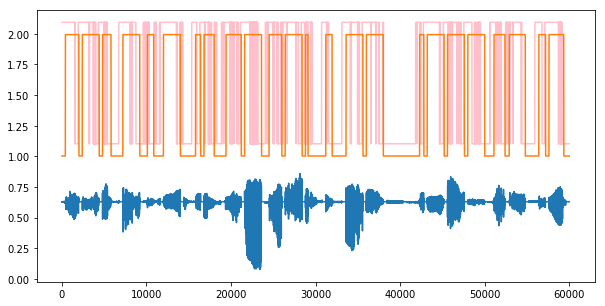

In [55]:
plt.figure(figsize = [10, 5])
plt.plot(testX[0:60000,0, 0])
plt.plot(testPredict[0:60000] + 1.1, c= 'pink')
plt.plot(testY[0,0:60000] + 1)

In [56]:
# merge 1's
# exclude short sequences
cc = (testPredict[0:60000] > 0.5)
lengths = np.array([[k, sum(1 for _ in i)] for k, i in it.groupby(cc)])
#print(lengths)
#plt.plot(cc*1.0)

lengths[(lengths[:,1]<300) & (lengths[:,0] == 0) ,0] = True
lengths[(lengths[:,1]>=700) & (lengths[:,0] == 0),0] = False

lengths[:,0]
lengths[:,1].astype(int)
keepers = np.repeat(lengths[:,0], lengths[:,1].astype(int))


cc = keepers
lengths = np.array([[k, sum(1 for _ in i)] for k, i in it.groupby(cc)])
#print(lengths)
#plt.plot(cc*1.0)

lengths[(lengths[:,1]<300) & (lengths[:,0] == 1) ,0] = False
keepers2 = np.repeat(lengths[:,0], lengths[:,1].astype(int))


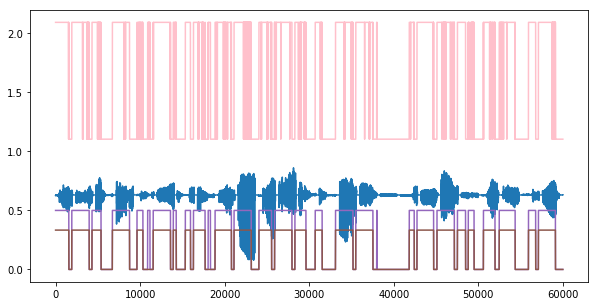

In [57]:
plt.figure(figsize = [10, 5])



plt.plot(testX[0:60000,0, 0])
plt.plot(testPredict[0:60000] + 1.1, c= 'pink')
plt.plot(testY[0:60000] + 1)
plt.plot(keepers / 2)

plt.plot(keepers2 / 3)


In [58]:
# calculate accuracy on whole test set
# exclude short sequences
cc = (testPredict > 0.5)
lengths = np.array([[k, sum(1 for _ in i)] for k, i in it.groupby(cc)])
#print(lengths)
#plt.plot(cc*1.0)

lengths[(lengths[:,1]<300) & (lengths[:,0] == 0) ,0] = True
lengths[(lengths[:,1]>=700) & (lengths[:,0] == 0),0] = False

lengths[:,0]
lengths[:,1].astype(int)
keepers = np.repeat(lengths[:,0], lengths[:,1].astype(int))


cc = keepers
lengths = np.array([[k, sum(1 for _ in i)] for k, i in it.groupby(cc)])
#print(lengths)
#plt.plot(cc*1.0)

lengths[(lengths[:,1]<300) & (lengths[:,0] == 1) ,0] = False
keepers2 = np.repeat(lengths[:,0], lengths[:,1].astype(int))


In [59]:
from sklearn.metrics import accuracy_score

In [60]:
((testY > 0.5)*1.0).astype(int)[0,:]

array([0, 0, 0, ..., 1, 1, 1])

In [61]:
accuracy_score(((testY > 0.5)*1.0).astype(int)[0,:], keepers2.astype(int))

0.6659469592361059

In [62]:
# accuracy on training set
accuracy_score(((trainY > 0.5)*1.0).astype(int)[0,:], (trainPredict>0.5).astype(int))

0.8981707113529392

In [65]:
trainX.shape, trainPredict.shape, trainY.shape

((359484, 1, 500), (359484, 1), (1, 359484))

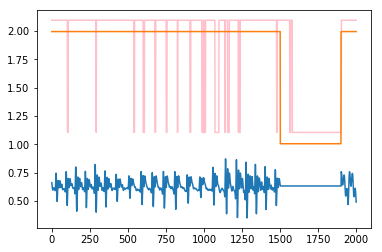

In [75]:
plt.plot(trainX[0:2000,0, -1])
plt.plot(trainPredict[0:2000, 0] + 1.1, c= 'pink')
plt.plot(trainY[0, 0:2000] + 1)



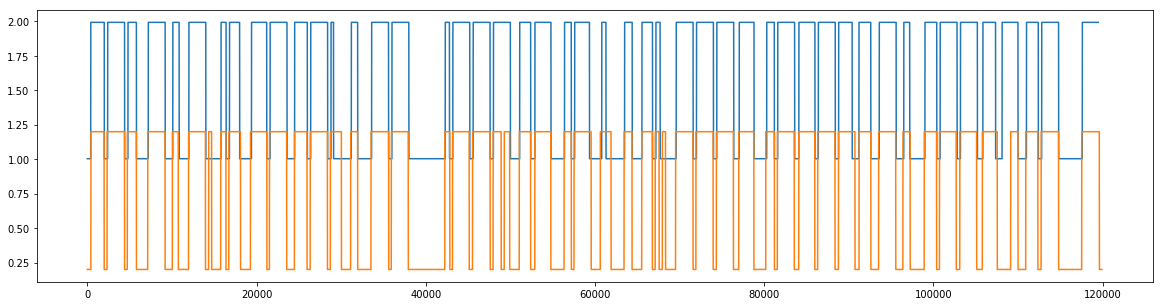

In [41]:
plt.figure(figsize = [20, 5])
plt.plot(testY[0,0:] + 1)
#plt.plot(keepers2.astype(int))
k2 = np.hstack([np.zeros(420), keepers2])
plt.plot(k2 + 0.2)

In [42]:
for jj in np.arange(400, 550, step = 10):
    k2 = np.hstack([np.zeros(jj), keepers2])
    asc = accuracy_score(((testY > 0.5)*1.0).astype(int)[0,:], k2[0:testY.shape[1]].astype(int))
    print(asc, jj)

0.9140200681211452 400
0.9200287882972225 410
0.9254684374816935 420
0.9300377427966492 430
0.933602805185241 440
0.9355778162737566 450
0.9366155339643326 460
0.9363644732327416 470
0.9348413714610898 480
0.9324311884378165 490
0.9282133681470881 500
0.9218866377109957 510
0.9151247353401455 520
0.9079611357987497 530
0.9005632129078691 540


In [ ]:
testY.shape